# Helper Functions

In [34]:
def phase_shift_signal(
    L,
    dx,
    n,
    n_terms,
    psi
):

    A0 = np.sum(f*np.ones_like(x))*dx

    fFS = A0/ (2 * n_terms)

    n_terms = 100

    A = np.zeros(n_terms)
    B = np.zeros(n_terms)

    for k in range(n_terms):
    
        A[k] = (np.sum(f*np.cos(2 * np.pi*(k+1)*(x)/ L)) * dx) / n_terms
        B[k] = (np.sum(f*np.sin(2 * np.pi*(k+1)*(x)/ L)) * dx) / n_terms
    
        fFS += (A[k] * np.cos((k+1) * 2 * np.pi * (x-psi)/ L) + B[k] * np.sin((k+1) * 2 * np.pi * (x-psi)/ L)) 


# Loading in Data

In [1]:
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import mne
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs

sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(
    sample_data_folder, "MEG", "sample", "sample_audvis_filt-0-40_raw.fif"
)
raw = mne.io.read_raw_fif(sample_data_raw_file)

# Here we'll crop to 60 seconds and drop gradiometer channels for speed
raw.crop(tmax=60.0).pick_types(meg="mag", eeg=True, stim=True, eog=True)
raw.load_data()

Opening raw data file C:\Users\20gun\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Reading 0 ... 9009  =      0.000 ...    59.999 secs...


<Raw | sample_audvis_filt-0-40_raw.fif, 171 x 9010 (60.0 s), ~14.8 MB, data loaded>

Using matplotlib as 2D backend.


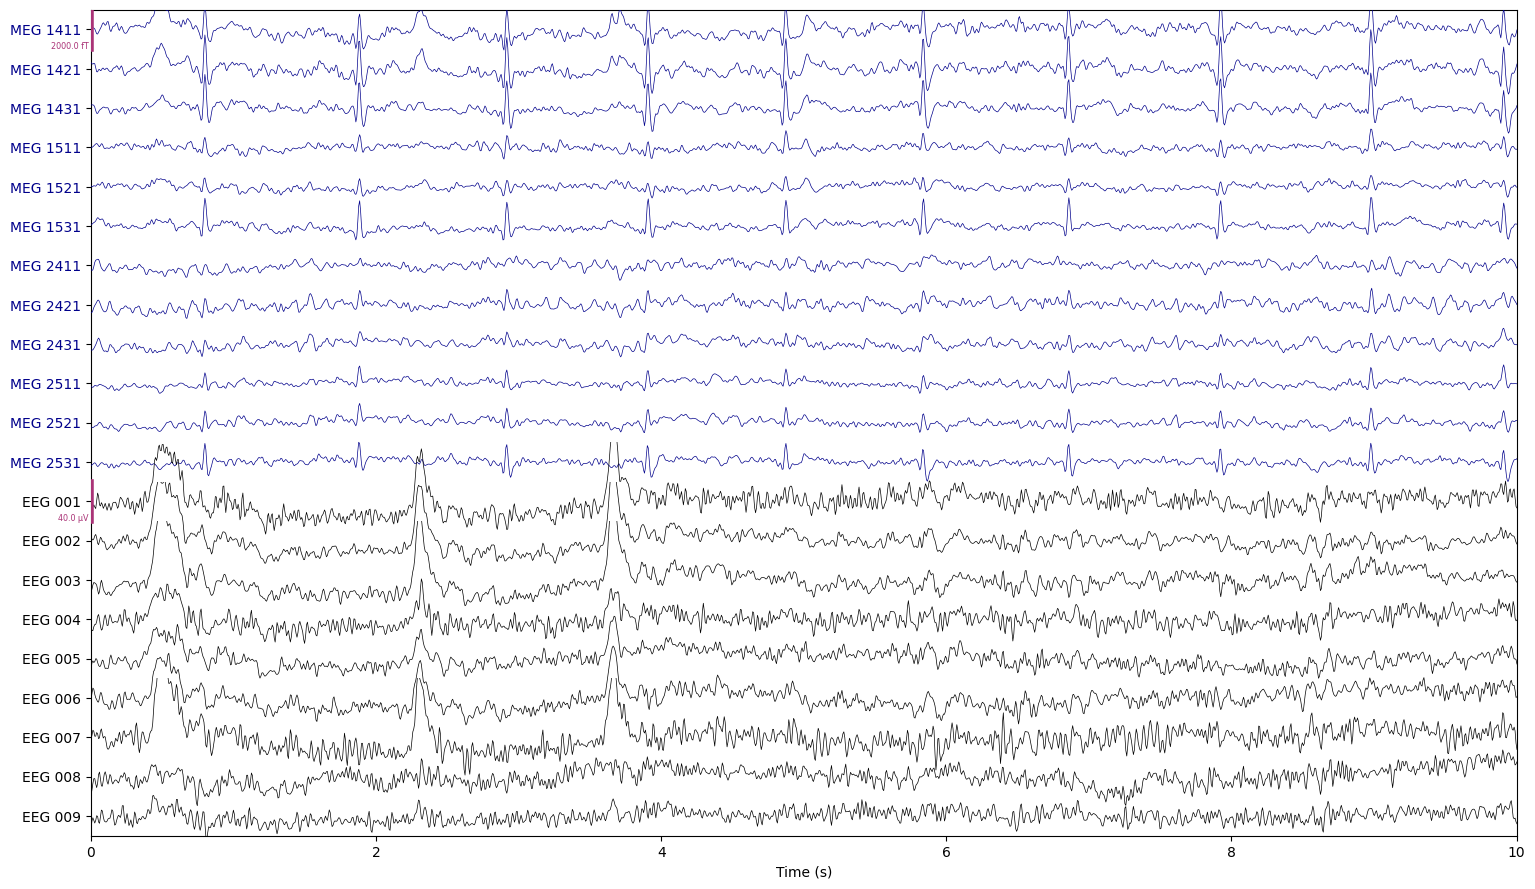

In [4]:
# pick some channels that clearly show heartbeats and blinks
regexp = r"(MEG [12][45][123]1|EEG 00.)"
artifact_picks = mne.pick_channels_regexp(raw.ch_names, regexp=regexp)
raw.plot(order=artifact_picks, n_channels=len(artifact_picks), show_scrollbars=False);

In [5]:
filt_raw = raw.copy().filter(l_freq=1.0, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 497 samples (3.310 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


In [6]:
ica = ICA(n_components=15, max_iter="auto", random_state=97)
ica.fit(filt_raw);

Fitting ICA to data using 161 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.0s.


Creating RawArray with float64 data, n_channels=16, n_times=9010
    Range : 6450 ... 15459 =     42.956 ...   102.954 secs
Ready.


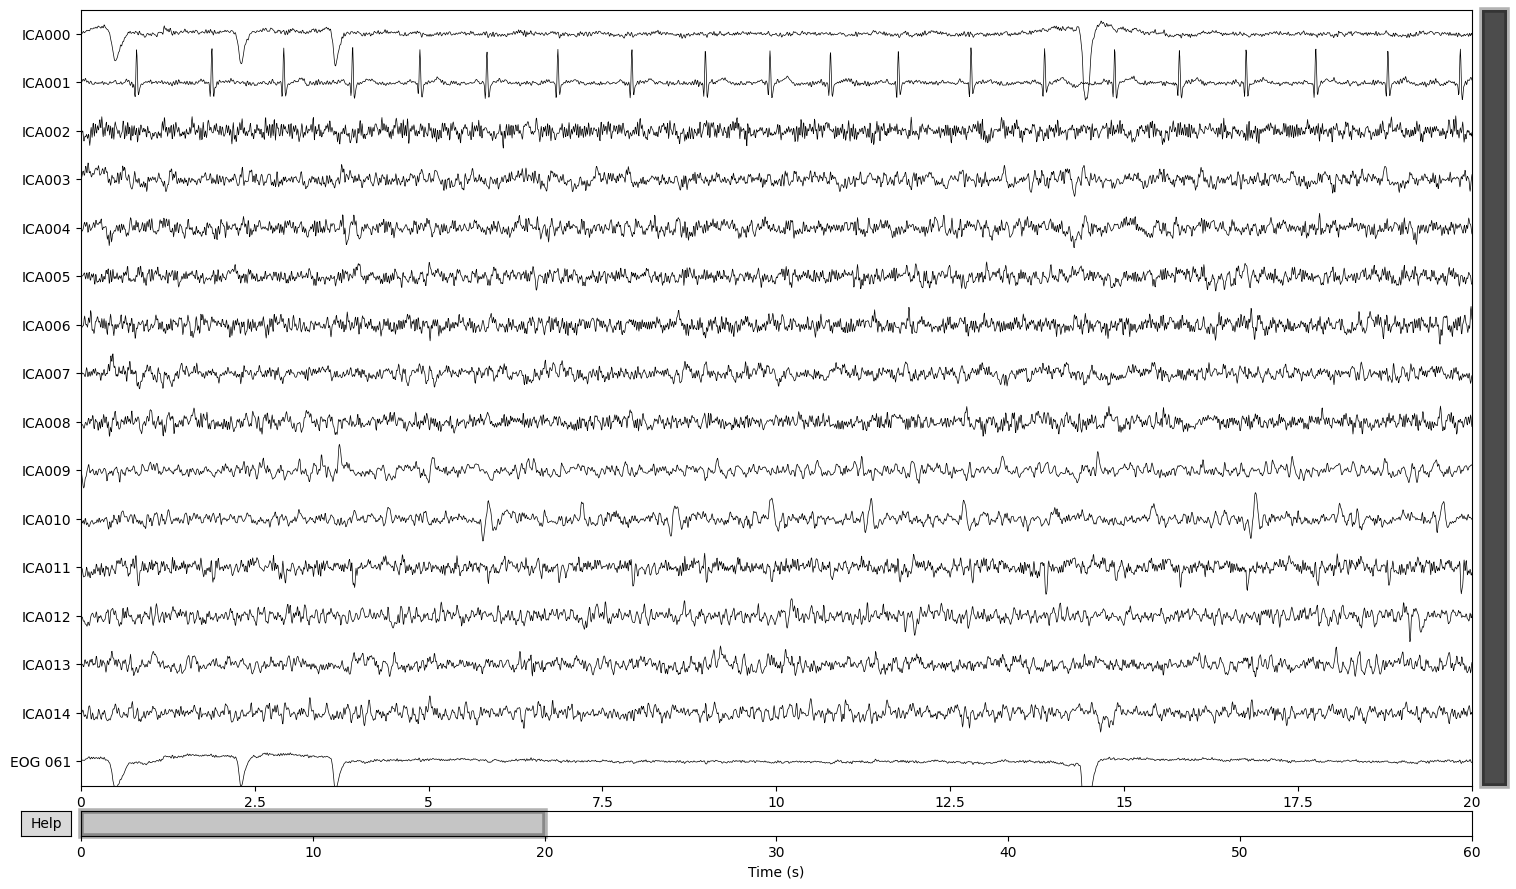

In [7]:
ica.plot_sources(filt_raw);

### Getting Fourier Series Approximation of ICA000

In [8]:
sources_as_numpy = ica.get_sources(filt_raw).get_data()

In [9]:
#Getting first 15 seconds
ICA000 = sources_as_numpy[0,:int(15*raw.info['sfreq'])]

In [10]:
ICA000.shape

(2252,)

In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams.update({'font.size':18})

In [13]:
dx = 0.001
L = np.pi
x = L*np.arange(-1+dx,1+dx,dx)
n = len(x)
nquart = int(np.floor(n/4))

In [14]:
f = np.zeros_like(x)
f[nquart:2*nquart] = (4/n) * np.arange(1,nquart+1)
f[nquart*2:nquart*3] = np.ones(nquart) - (4/n) * np.arange(0,nquart)

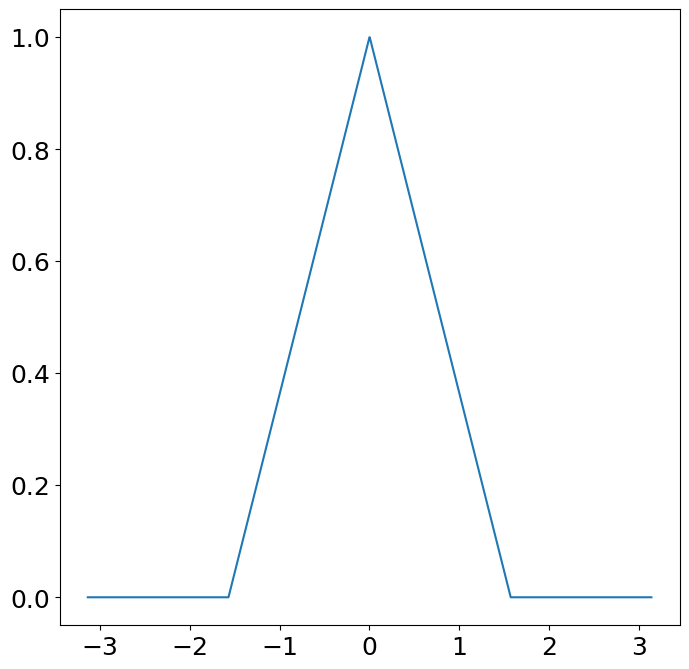

In [15]:
plt.plot(x,f);
plt.show();

In [16]:
A0 = np.sum(f*np.ones_like(x))*dx

fFS = A0/2

n_terms = 20

A = np.zeros(n_terms)
B = np.zeros(n_terms)

#phase shift
psi = np.pi/4

for k in range(n_terms):

    A[k] = np.sum(f*np.cos(np.pi*(k+1)*(x)/L)) * dx
    B[k] = np.sum(f*np.sin(np.pi*(k+1)*(x)/L)) * dx

    fFS = fFS + A[k] * np.cos((k+1) * np.pi * (x - psi)/ L) + B[k] * np.sin((k+1) * np.pi * (x - psi)/ L)

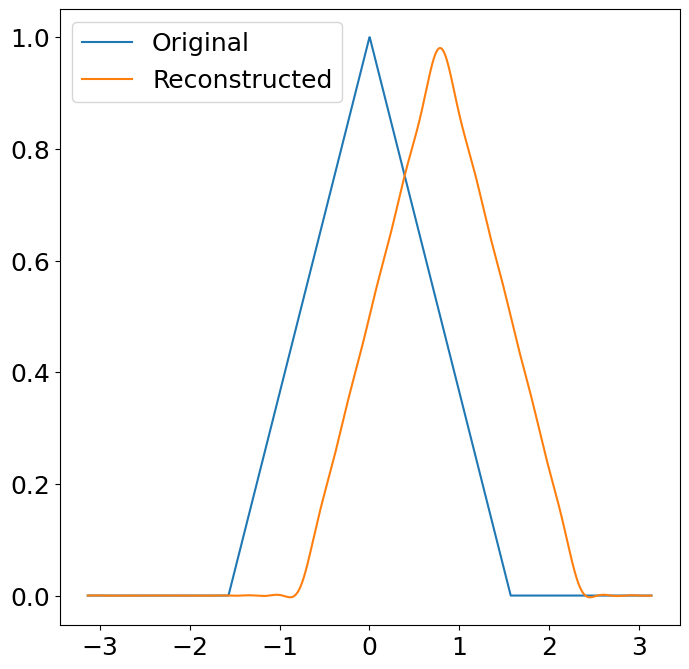

In [17]:
plt.plot(x,f);
plt.plot(x,fFS);

plt.legend(['Original','Reconstructed'])

plt.show();

In [18]:
f = ICA000[400:600]
x = np.arange(len(f))
L = 200
n = len(x)
dx = 1

Now testing with the eye blink artifact

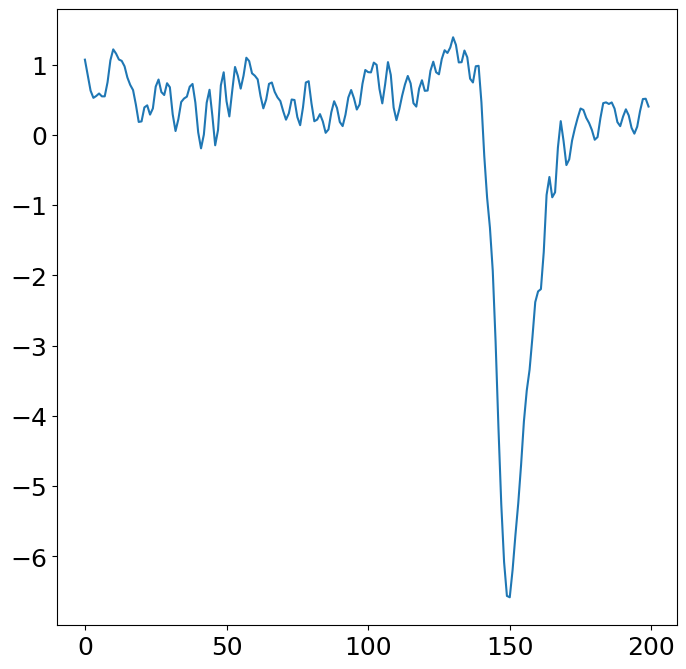

In [19]:
plt.plot(x,f);
plt.show();

Now, let's compute the Fourier Series Approximation as we did before with the triangle wave

In [30]:
A0 = np.sum(f*np.ones_like(x))*dx

fFS = A0/ (2 * n_terms)

n_terms = 100

A = np.zeros(n_terms)
B = np.zeros(n_terms)

#phase shift
psi = 2

for k in range(n_terms):

    A[k] = (np.sum(f*np.cos(2 * np.pi*(k+1)*(x)/ L)) * dx) / n_terms
    B[k] = (np.sum(f*np.sin(2 * np.pi*(k+1)*(x)/ L)) * dx) / n_terms

    fFS += (A[k] * np.cos((k+1) * 2 * np.pi * (x-psi)/ L) + B[k] * np.sin((k+1) * 2 * np.pi * (x-psi)/ L)) 


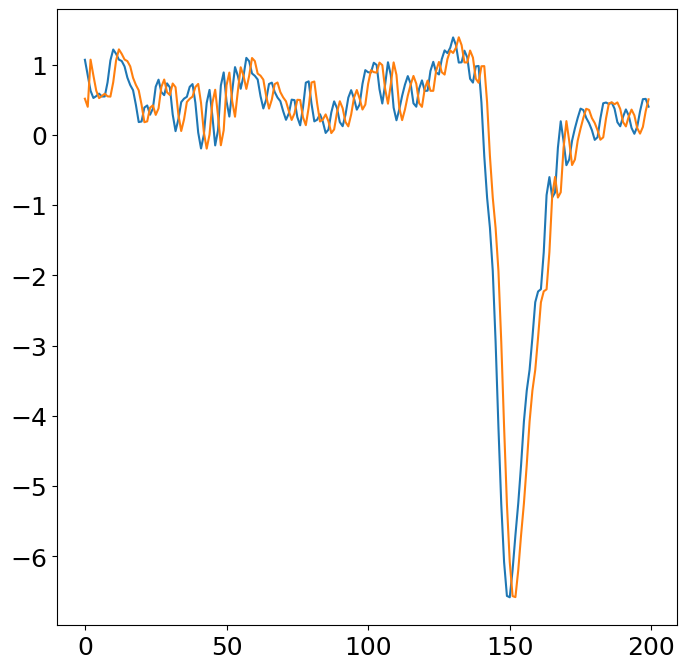

In [31]:
plt.plot(x,f);
plt.plot(x,fFS);

plt.show();